<a href="https://colab.research.google.com/github/bhuvnk/EVA6/blob/main/Session%204%20Backpropagation%20and%20Architectural%20Basics/EVA6_S04_MNIST_995_19_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # dims : [28,28,1];
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, bias=False), # 26
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.069),
            # RF - 3x3

            nn.Conv2d(8, 16, 3, bias=False), # 24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.069),
            # RF - 5x5

            nn.Conv2d(16, 32, 3, bias=False), # 22
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.069),
            # RF - 7x7
        )

        # dims : [22x22x32]
        # Bottle neck - Transition layer

        self.trans1 = nn.Sequential(
            nn.Conv2d(32, 8, 1, bias=False), # 22
            nn.ReLU(),
            # RF - 7x7

            nn.MaxPool2d(2, 2), # 11
            # RF - 14x14
        )

        # dims : [11x11x8]
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 8, 3, bias=False), # 9
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.069),
            # RF - 16x16

            nn.Conv2d(8, 16, 3, bias=False), # 7
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.069),
            # RF - 18x18

            nn.Conv2d(16, 32, 3, bias=False), # 5
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.069),
            # RF - 20x20
        )

        # dims : 5x5x32

        # GAP Layer
        self.out = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),       # 
            nn.Conv2d(32, 10, 1, bias=False), # 5
            # RF - 22x22
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.out(x)

        x = x.view(-1, 10)
        return F.log_softmax(x)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
         Dropout2d-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 22, 22]           4,608
             ReLU-10           [-1, 32, 22, 22]               0
      BatchNorm2d-11           [-1, 32, 22, 22]              64
        Dropout2d-12           [-1, 32, 22, 22]               0
           Conv2d-13            [-1, 8, 22, 22]             256
             ReLU-14            [-1, 8,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        # transforms.RandomRotation((-5.0, 5.0), fill=(1,)), # Added asjed
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [5]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch):
    model.train()

    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        # init by setting the gradients to zero
        optimizer.zero_grad()

        #Predict
        output = model(data)

        #Loss Calculation
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        
        # BackProp
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [6]:
N_EPOCH = 19
BASE_LR = 0.001
MAX_LR = 0.15
STEP_UP = int(N_EPOCH/5)

from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                  BASE_LR, MAX_LR, 
                                  step_size_up=STEP_UP, 
                                  step_size_down=N_EPOCH-STEP_UP-1)


for epoch in range(1, N_EPOCH+1):
    print('\nEpoch {} and Learning Rate {}: '.format(epoch, scheduler.get_last_lr()))
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 1 and Learning Rate [0.001]: 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.8820855617523193 batch_id=468 Accuracy=60.73: 100%|██████████| 469/469 [00:12<00:00, 38.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7884, Accuracy: 8876/10000 (88.76%)


Epoch 2 and Learning Rate [0.050666666666666686]: 


loss=0.15036989748477936 batch_id=468 Accuracy=94.86: 100%|██████████| 469/469 [00:12<00:00, 38.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9835/10000 (98.35%)


Epoch 3 and Learning Rate [0.10033333333333337]: 


loss=0.09188706427812576 batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:12<00:00, 38.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9900/10000 (99.00%)


Epoch 4 and Learning Rate [0.14999999999999997]: 


loss=0.03987995907664299 batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:11<00:00, 39.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9888/10000 (98.88%)


Epoch 5 and Learning Rate [0.14006666666666662]: 


loss=0.021781722083687782 batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:11<00:00, 39.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9917/10000 (99.17%)


Epoch 6 and Learning Rate [0.13013333333333332]: 


loss=0.061160922050476074 batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:11<00:00, 40.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9914/10000 (99.14%)


Epoch 7 and Learning Rate [0.1202]: 


loss=0.06803696602582932 batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:11<00:00, 39.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9921/10000 (99.21%)


Epoch 8 and Learning Rate [0.11026666666666667]: 


loss=0.09194263070821762 batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:11<00:00, 39.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9920/10000 (99.20%)


Epoch 9 and Learning Rate [0.10033333333333333]: 


loss=0.048548389226198196 batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:11<00:00, 39.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9932/10000 (99.32%)


Epoch 10 and Learning Rate [0.0904]: 


loss=0.019084611907601357 batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:11<00:00, 39.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9937/10000 (99.37%)


Epoch 11 and Learning Rate [0.08046666666666666]: 


loss=0.04142606630921364 batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:12<00:00, 38.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)


Epoch 12 and Learning Rate [0.07053333333333331]: 


loss=0.014714610762894154 batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:12<00:00, 38.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)


Epoch 13 and Learning Rate [0.060600000000000015]: 


loss=0.08749005198478699 batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:11<00:00, 39.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9933/10000 (99.33%)


Epoch 14 and Learning Rate [0.050666666666666645]: 


loss=0.00690600136294961 batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:12<00:00, 38.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)


Epoch 15 and Learning Rate [0.04073333333333335]: 


loss=0.008589586243033409 batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:11<00:00, 39.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.35%)


Epoch 16 and Learning Rate [0.030799999999999973]: 


loss=0.009844587184488773 batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:11<00:00, 39.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)


Epoch 17 and Learning Rate [0.020866666666666676]: 


loss=0.014452454634010792 batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 38.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99.41%)


Epoch 18 and Learning Rate [0.010933333333333337]: 


loss=0.009997005574405193 batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 38.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9950/10000 (99.50%)


Epoch 19 and Learning Rate [0.001]: 


loss=0.019175216555595398 batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 39.35it/s]



Test set: Average loss: 0.0168, Accuracy: 9953/10000 (99.53%)



# Logs

Text(0.5, 1.0, 'Test Accuracy')

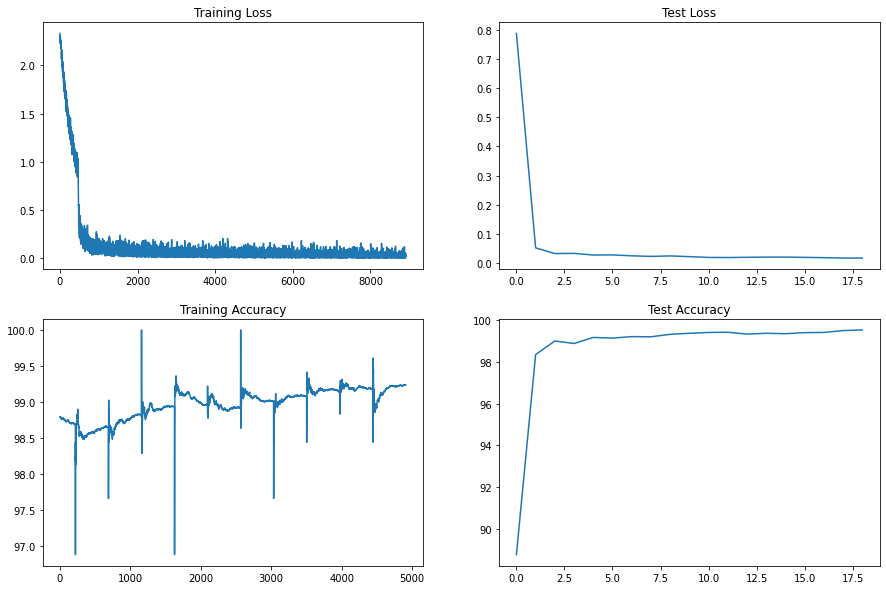

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")